# StyleCLIP+: Inference Speed Improvement
Fall 2023 CS470 Introduction to Artificial Intelligence Project 2 (Implementation), Team 3  
Myeongseok Kwon<sup>1</sup>, Junhak Ha<sup>2</sup>, Dongwan Hong<sup>3</sup>, Kyeongmin Lee<sup>4</sup>, Bryan Nathanael Wijaya<sup>5*</sup>  
<small><sup>1</sup>20170042, <sup>2</sup>20190683, <sup>3</sup>20190696, <sup>4</sup>20200429, <sup>5</sup>20200735, <sup>*</sup>Team Leader</small>

**Remarks:** This notebook is extended from the implementation by Dongbin Na.

### <b>StyleCLIP Tutorial</b>

* This is a simple tutorial with source code for <b>[StyleCLIP](https://arxiv.org/abs/2103.17249)</b>.
* <b>Reference</b>: [Original StyleCLIP source code](https://github.com/orpatashnik/StyleCLIP)

#### <b>Install CLIP</b>

* CLIP jointly trains an image encoder and a text encoder using a large dataset.
* The cosine similarity between an image and text feature is high if they have similar semantic meanings.

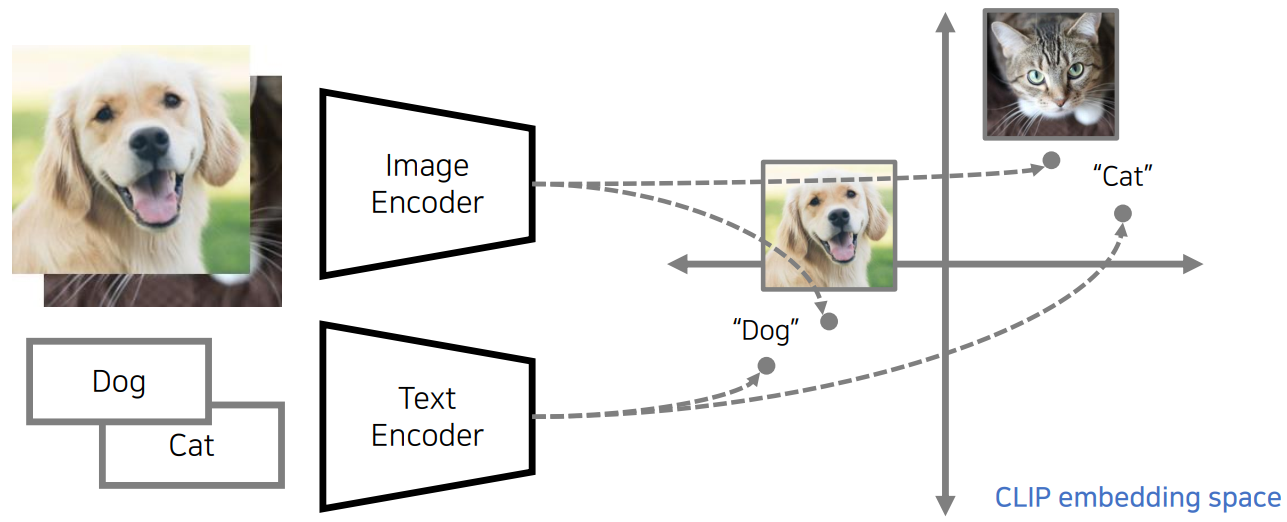

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.7 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-oej2isbm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-oej2isbm
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=704e2317b3e6f928ae8c73297e40d2130650fbe1cd7ab871cc1ea56bf8c01edb
  Stored in directory: /tmp/pip-ephem-wheel-cache-lan2z2ba/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


#### <b>Load the Pre-trained StyleGAN Model</b>

* StyleGAN is an efficient architecture to generate high-quality images.

In [2]:
!git clone https://github.com/ndb796/StyleCLIP-Tutorial
%cd StyleCLIP-Tutorial

Cloning into 'StyleCLIP-Tutorial'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 64 (delta 19), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (64/64), 3.33 MiB | 13.22 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/StyleCLIP-Tutorial


In [3]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1 -O stylegan2-ffhq-config-f.pt

--2023-12-11 09:31:51--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1 [following]
--2023-12-11 09:31:53--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 381462551 (364M) [application/octet-stream]
Saving to: ‘stylegan2-ffhq-config-f.pt’

stylegan2-ffhq-conf 100%[===================>] 363.79M  66.5MB/s    in 11s     


In [4]:
import torch
from stylegan2.model import Generator


g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()

#### <b>CLIP Loss</b>

In [5]:
import clip


class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

#### <b>Latent Optimization</b>

* The basic idea is as follows:

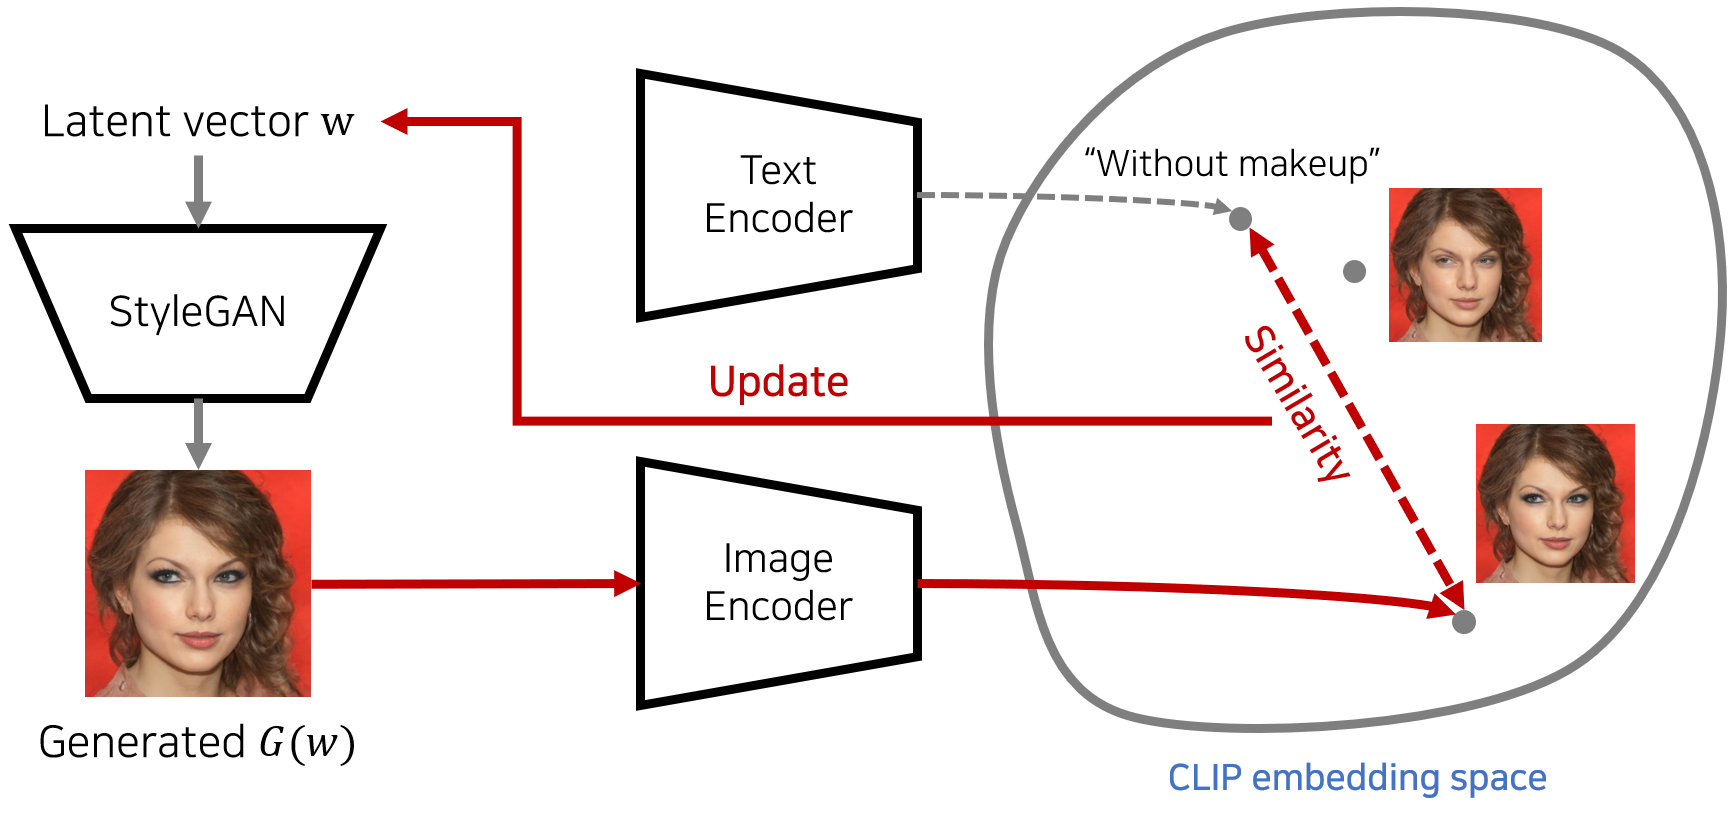

* Initialize a random latent vector using a mean latent vector.

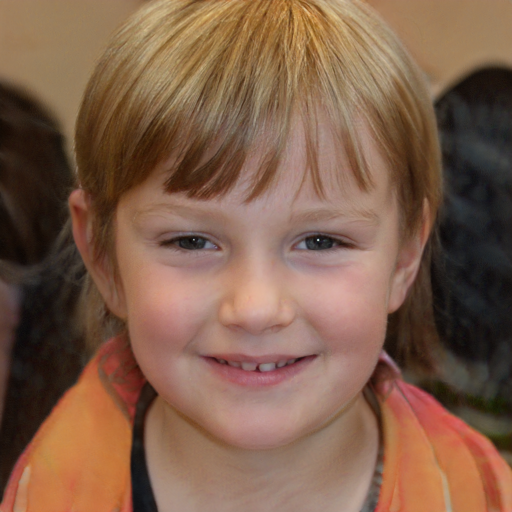

In [36]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage


mean_latent = g_ema.mean_latent(4096)

latent_code_init_not_trunc = torch.randn(1, 512).cuda()
with torch.no_grad():
    img_orig, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
                                truncation=0.7, truncation_latent=mean_latent)

# Visualize a random latent vector.
image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, padding=0))
h, w = image.size
image.resize((h // 2, w // 2))

* The optimization method updates the $w$ vector.
* In this source code, we use only $D_{CLIP}(G(w),t) + \lambda_{L2} ||w-w_s||_2$.

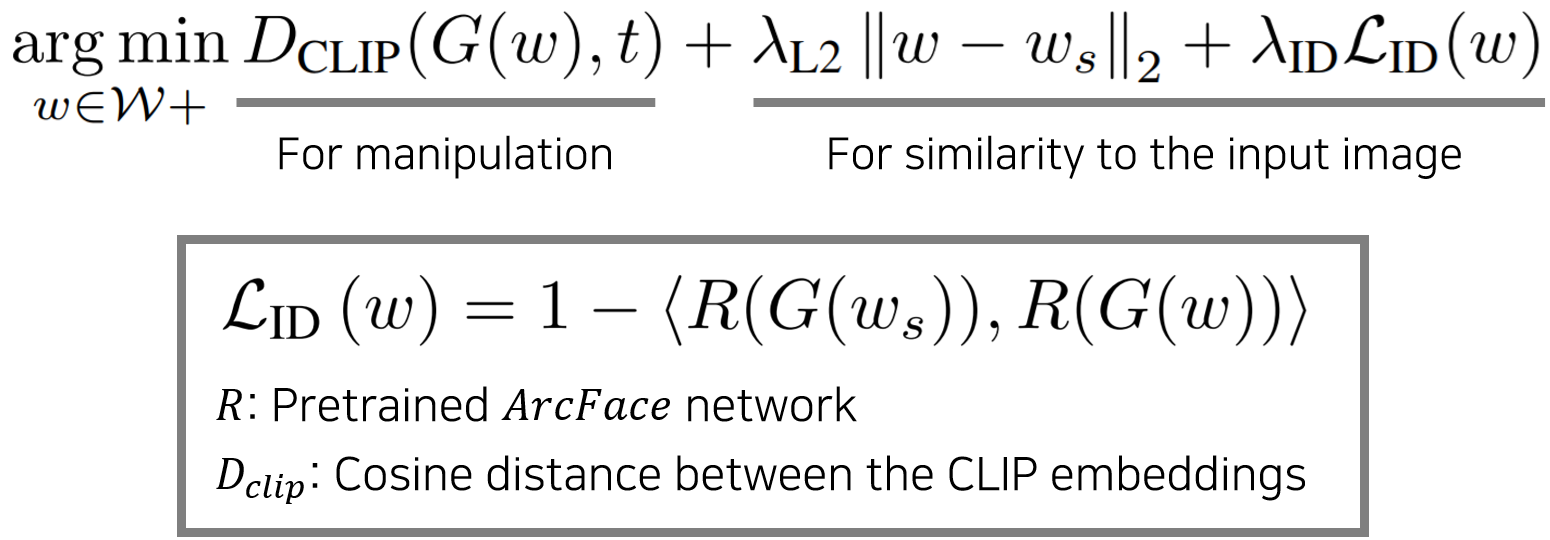

* Set parameters for a practice.

In [37]:
from argparse import Namespace


args = Namespace()
args.description = 'A really sad face'
args.lr_rampup = 0.05
args.lr = 0.1
args.step = 150
args.l2_lambda = 0.005 # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir = 'results'
args.early_terminate = True
args.k = 3
args.threshold = 1

* Optimize a latent vector and get the result.

In [44]:
import os
import math
import torchvision
from torch import optim
#from torch.linalg import vector_norm

# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir, exist_ok=True)

# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)

latents = [latent_code_init]
for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr)
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    loss = c_loss + args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    latents.append(latent.detach().clone())

    # Log the current state.

    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True)

    # Check for early termination.
    if args.early_terminate and i >= args.k:
        deltaW = 0
        for j in range(args.k):
            deltaW += abs((latents[-1] - latents[-2-j]).sum())
        if deltaW < args.threshold:
            print(f"iteration: {i+1:3d}, lr: {lr:1.6f}, loss: {loss.item():1.4f}, deltaW: {deltaW:3.4f}")
            print(f"Early terminated at the {i+1}th iteration.")
            break
        print(f"iteration: {i+1:3d}, lr: {lr:1.6f}, loss: {loss.item():1.4f}, deltaW: {deltaW:3.4f}")

    else:
        print(f"iteration: {i+1:3d}, lr: {lr:1.6f}, loss: {loss.item():1.4f}")


with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True)

iteration:   1, lr: 0.000000, loss: 0.7686
iteration:   2, lr: 0.013333, loss: 0.7686
iteration:   3, lr: 0.026667, loss: 0.7573
iteration:   4, lr: 0.040000, loss: 0.7725, deltaW: 14.0288
iteration:   5, lr: 0.053333, loss: 0.7900, deltaW: 37.0073
iteration:   6, lr: 0.066667, loss: 0.7866, deltaW: 61.8337
iteration:   7, lr: 0.080000, loss: 0.7896, deltaW: 32.3748
iteration:   8, lr: 0.093333, loss: 0.7876, deltaW: 30.7815
iteration:   9, lr: 0.100000, loss: 0.7905, deltaW: 52.0164
iteration:  10, lr: 0.100000, loss: 0.7881, deltaW: 39.6973
iteration:  11, lr: 0.100000, loss: 0.7871, deltaW: 14.9526
iteration:  12, lr: 0.100000, loss: 0.7681, deltaW: 29.6138
iteration:  13, lr: 0.100000, loss: 0.7686, deltaW: 20.6446
iteration:  14, lr: 0.100000, loss: 0.7710, deltaW: 11.9490
iteration:  15, lr: 0.100000, loss: 0.7739, deltaW: 19.6704
iteration:  16, lr: 0.100000, loss: 0.7690, deltaW: 10.3298
iteration:  17, lr: 0.100000, loss: 0.7686, deltaW: 9.2675
iteration:  18, lr: 0.100000, lo

#### <b>Result Visualization</b>

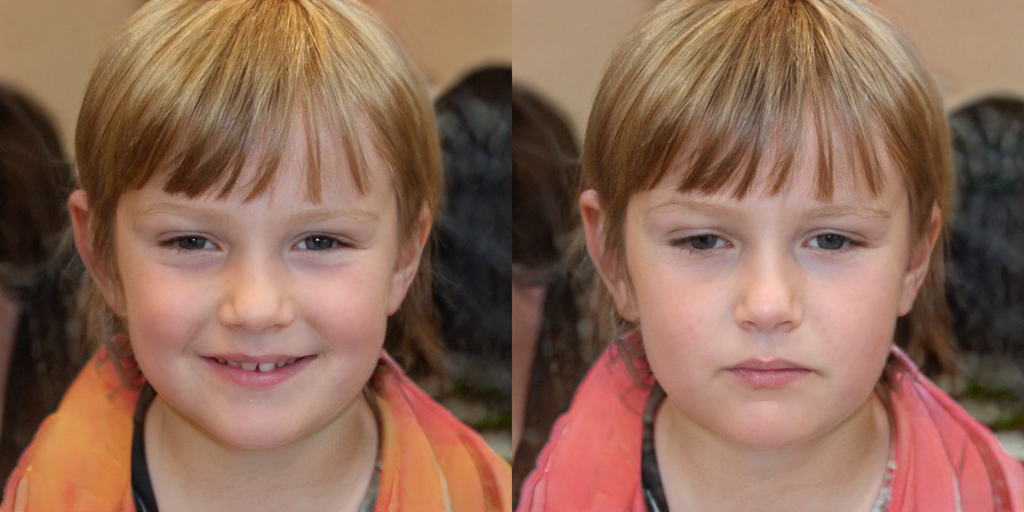

In [45]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

* Generate an animation video and download the video.

In [47]:
!ffmpeg -r 15 -i results/%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4

from google.colab import files
files.download('out.mp4')

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>